In [68]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
data=pd.read_csv('/Users/yybai/Desktop/customer segementation/Mall_Customers.csv')

In [17]:
def basic_explore():
    print('Data shape', data.shape)
    print('\n')
    ## number of nans for each col, ascendng
    print('Check number of nans for each col in train')
    print(data.isnull().sum(axis=0).sort_values(ascending=False).head(25))
    print('Check number of nans for each col in test')
    print(data.isnull().sum(axis=0).sort_values(ascending=False).head(25))
    print('\n')
    ## number of unique val for each col, ascending
    print('Check number of unique value for each col in train')
    print(data.nunique(dropna=False).sort_values().head(20))
    print('\n')
    print(data.describe())
    print('\n')
    print(data.dtypes)
basic_explore()

Data shape (200, 5)


Check number of nans for each col in train
Spending Score (1-100)    0
Annual Income (k$)        0
Age                       0
Gender                    0
CustomerID                0
dtype: int64
Check number of nans for each col in test
Spending Score (1-100)    0
Annual Income (k$)        0
Age                       0
Gender                    0
CustomerID                0
dtype: int64


Check number of unique value for each col in train
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
CustomerID                200
dtype: int64


       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000

In [24]:
data['Gender']=data['Gender'].apply(str)

Text(0.5, 1.0, 'Male')

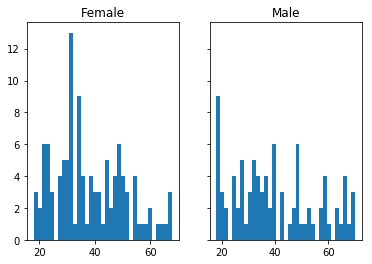

In [60]:
f=data.groupby('Gender').get_group('Female')['Age']
m=data.groupby('Gender').get_group('Male')['Age']
fig,axs=plt.subplots(1, 2, sharey=True, tight_layout=False)
axs[0].hist(f,bins=35)
axs[0].set_title("Female")
axs[1].hist(m,bins=35)
axs[1].set_title("Male")

Text(0.5, 1.0, 'Male')

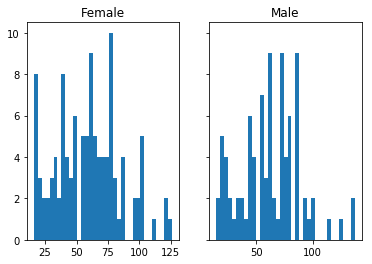

In [58]:
f=data.groupby('Gender').get_group('Female')['Annual Income (k$)']
m=data.groupby('Gender').get_group('Male')['Annual Income (k$)']
fig,axs=plt.subplots(1,2,sharey=True,tight_layout=False)
axs[0].hist(f,bins=35)
axs[0].set_title("Female")
axs[1].hist(m,bins=35)
axs[1].set_title("Male")

Text(0.5, 1.0, 'Male')

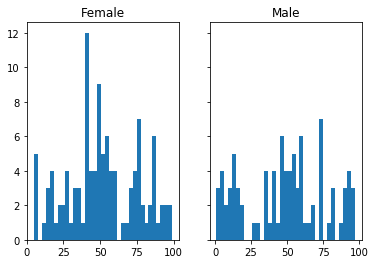

In [59]:
f=data.groupby('Gender').get_group('Female')['Spending Score (1-100)']
m=data.groupby('Gender').get_group('Male')['Spending Score (1-100)']
fig,axs=plt.subplots(1, 2, sharey=True, tight_layout=False)
axs[0].hist(f,bins=35)
axs[0].set_title("Female")
axs[1].hist(m,bins=35)
axs[1].set_title("Male")

All variables don't have outliers, but also unbalanced. this is mainly caused by the small amount of data

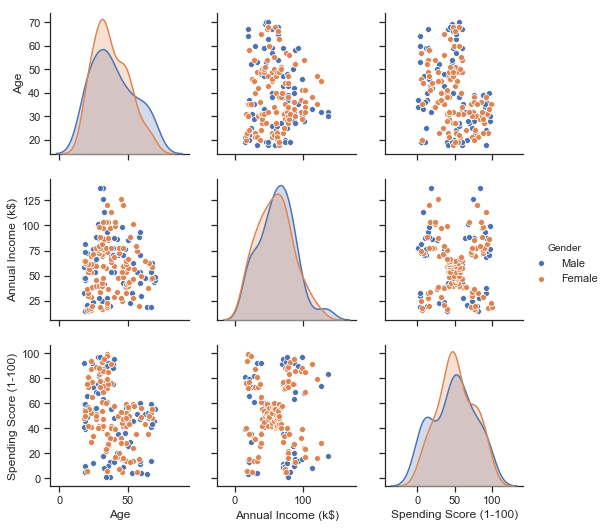

In [67]:
sns.set(style="ticks")
sns.pairplot(data.drop(columns='CustomerID'),hue='Gender')

Scatter Matrix shows no clear pattern of relationship between any feature. Also, see that Gender cannot contribute to segmentation.

In [85]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
trans=scaler.fit_transform(data[['Age','Spending Score (1-100)','Annual Income (k$)']])
data['Age']=trans[:,0]
data['Spending Score (1-100)']=trans[:,1]
data['Annual Income (k$)']=trans[:,2]

/Users/yybai/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/yybai/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [95]:
trans=pd.get_dummies(data).reset_index(drop=True)

In [179]:
trans.drop(columns='CustomerID').head(5)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,-1.424569,-1.738999,-0.434801,0,1
1,-1.281035,-1.738999,1.195704,0,1
2,-1.352802,-1.700830,-1.715913,1,0
3,-1.137502,-1.700830,1.040418,1,0
4,-0.563369,-1.662660,-0.395980,1,0


In [205]:
from sklearn.manifold import TSNE
tsne=TSNE(perplexity=55,n_iter=800)
tsne_results=tsne.fit_transform(trans[['Age','Annual Income (k$)','Spending Score (1-100)']].values)

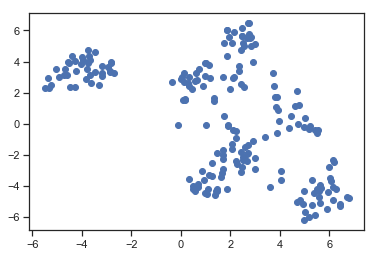

In [206]:
vis_x=tsne_results[:, 0]
vis_y=tsne_results[:, 1]
plt.scatter(vis_x, vis_y)
plt.show()

From the result of t-SNE, there should be at least 2 groups significantly separated from others. However, the rest are not easy to segment, mainly due to the small amount of data. By the basic trend, it seems that there might be another 3 groups.

In [209]:
use=trans[['Age','Annual Income (k$)','Spending Score (1-100)']]

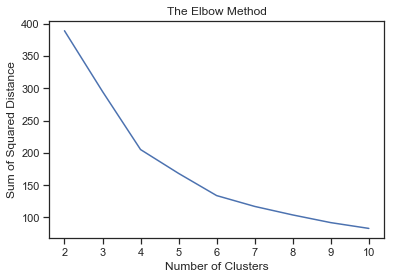

In [210]:
from sklearn.cluster import KMeans

distance=[]
for i in range(2, 11):
    k=KMeans(n_clusters=i)
    k.fit(use)
    distance.append(k.inertia_)
  
plt.plot(range(2, 11),distance)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distance')
plt.show()

By plot, k=6 is the best choice.

In [211]:
model=KMeans(n_clusters=6, init='k-means++')
model.fit(use)
pred=model.predict(use)

In [240]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected = True)

In [258]:
trace1=go.Scatter3d(x=use['Age'],y=use['Spending Score (1-100)'],z=use['Annual Income (k$)'],mode='markers',
                      marker=dict(color=model.labels_,size=8,line=dict(color=model.labels_),
                                  opacity=0.8,colorscale='Viridis',showscale=True))
data=[trace1]
layout=go.Layout(title='Clusters',scene=dict(xaxis=dict(title='Age'),
                                                  yaxis=dict(title='Spending Score'),
                                                  zaxis=dict(title='Annual Income')))
fig=go.Figure(data=data,layout=layout)
py.offline.iplot(fig)

Group 2 has several outliers that are far from cluster of the group, group 5 and 3 are sparse. Generally, due to the small amount of data, the segmentation is not very clear and clusters of group seem to spread instead of gathering closely. 